In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip --q install optuna xgboost catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.6 MB/s eta 0:00:00


# Loading Libraries and Datasets

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn import set_config
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from xgboost import XGBClassifier
from xgboost import DMatrix
from catboost import CatBoostClassifier
import xgboost
sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None
#optuna.logging.set_verbosity(optuna.logging.WARNING)

In [75]:
train_df = pd.read_csv(r'/content/drive/MyDrive/NSU-ML-Data/training.csv', index_col = 'patient_id')
test_df = pd.read_csv(r'/content/drive/MyDrive/NSU-ML-Data/test.csv', index_col = 'patient_id')

# Descriptive Statistics

In [76]:
train_df.head()

,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
patient_id,,,,,,,,,,,,,,,,,,,,,
475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,C773,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,C773,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
817482,NaN,COMMERCIAL,ID,836,55,F,NaN,1749,"Malignant neoplasm of breast (female), unspeci...",C773,...,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0


In [77]:
# Descriptive statistics of Training Dataset
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_zip3,12906.0,573.754300,275.447534,101.000000,331.000000,554.000000,846.000000,9.990000e+02
patient_age,12906.0,59.183326,13.335216,18.000000,50.000000,59.000000,67.000000,9.100000e+01
bmi,3941.0,28.984539,5.696906,14.000000,24.660000,28.190000,32.920000,8.500000e+01
population,12905.0,20744.441237,13886.903756,635.545455,9463.896552,19154.190480,30021.278690,7.137413e+04
density,12905.0,1581.950419,2966.305306,0.916667,171.857143,700.337500,1666.515385,2.117200e+04
age_median,12905.0,40.502259,4.036963,20.600000,37.129825,40.639344,42.934783,5.457000e+01
age_under_10,12905.0,11.122784,1.512376,0.000000,10.160000,11.039216,12.190000,1.767500e+01
age_10_to_19,12905.0,12.945265,1.923974,6.314286,11.741176,12.923944,14.019767,3.530000e+01
age_20s,12905.0,13.290376,3.354103,5.925000,11.013415,12.538095,14.971053,6.210000e+01
age_30s,12905.0,12.862036,2.324922,1.500000,11.292105,12.442647,14.026667,2.547143e+01


In [78]:
desc = pd.DataFrame(index = list(train_df))
desc['type'] = train_df.dtypes
desc['count'] = train_df.count()
desc['nunique'] = train_df.nunique()
desc['%unique'] = desc['nunique'] / len(train_df) * 100
desc['null'] = train_df.isnull().sum()
desc['%null'] = desc['null'] / len(train_df) * 100
desc

,type,count,nunique,%unique,null,%null
patient_race,object,6521,5,0.038742,6385,49.473113
payer_type,object,11103,3,0.023245,1803,13.970246
patient_state,object,12855,50,0.387417,51,0.395165
patient_zip3,int64,12906,739,5.726019,0,0.000000
patient_age,int64,12906,67,0.519138,0,0.000000
patient_gender,object,12906,1,0.007748,0,0.000000
bmi,float64,3941,1342,10.398264,8965,69.463815
breast_cancer_diagnosis_code,object,12906,50,0.387417,0,0.000000
breast_cancer_diagnosis_desc,object,12906,50,0.387417,0,0.000000
metastatic_cancer_diagnosis_code,object,12906,43,0.333178,0,0.000000


#### Following features has most null values in Training Dataset.
* `bmi` feature has 69% null values.
* `metastatic_first_novel_treatment` feature has 99% null values.
*  `metastatic_first_novel_treatment_type`	feature has 99% null values.
*  `patient_race` feature has 49% null values

> I will drop the above features from the training data and impute the null values of other features based on Imputer.




In [79]:
# Descriptive statistics of Test dataset
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_zip3,12906.0,573.754300,275.447534,101.000000,331.000000,554.000000,846.000000,9.990000e+02
patient_age,12906.0,59.183326,13.335216,18.000000,50.000000,59.000000,67.000000,9.100000e+01
bmi,3941.0,28.984539,5.696906,14.000000,24.660000,28.190000,32.920000,8.500000e+01
population,12905.0,20744.441237,13886.903756,635.545455,9463.896552,19154.190480,30021.278690,7.137413e+04
density,12905.0,1581.950419,2966.305306,0.916667,171.857143,700.337500,1666.515385,2.117200e+04
age_median,12905.0,40.502259,4.036963,20.600000,37.129825,40.639344,42.934783,5.457000e+01
age_under_10,12905.0,11.122784,1.512376,0.000000,10.160000,11.039216,12.190000,1.767500e+01
age_10_to_19,12905.0,12.945265,1.923974,6.314286,11.741176,12.923944,14.019767,3.530000e+01
age_20s,12905.0,13.290376,3.354103,5.925000,11.013415,12.538095,14.971053,6.210000e+01
age_30s,12905.0,12.862036,2.324922,1.500000,11.292105,12.442647,14.026667,2.547143e+01


In [80]:
desc = pd.DataFrame(index = list(test_df))
print(f"----->Information about Test Dataset")
desc['type'] = test_df.dtypes
desc['count'] = test_df.count()
desc['nunique'] = test_df.nunique()
desc['%unique'] = desc['nunique'] / len(test_df) * 100
desc['null'] = test_df.isnull().sum()
desc['%null'] = desc['null'] / len(test_df) * 100
desc

----->Information about Test Dataset


,type,count,nunique,%unique,null,%null
patient_race,object,2891,5,0.086326,2901,50.086326
payer_type,object,5032,3,0.051796,760,13.121547
patient_state,object,5771,46,0.794199,21,0.362569
patient_zip3,int64,5792,679,11.723066,0,0.000000
patient_age,int64,5792,67,1.156768,0,0.000000
patient_gender,object,5792,1,0.017265,0,0.000000
bmi,float64,1777,847,14.623619,4015,69.319751
breast_cancer_diagnosis_code,object,5792,46,0.794199,0,0.000000
breast_cancer_diagnosis_desc,object,5792,46,0.794199,0,0.000000
metastatic_cancer_diagnosis_code,object,5792,36,0.621547,0,0.000000


#### Following features has most null values in Test Dataset.
* `bmi` feature has **69%** null values.
* `metastatic_first_novel_treatment` feature has **99%** null values.
*  `metastatic_first_novel_treatment_type`	feature has **99%** null values.
*  `patient_race` feature has **50%** null values

I will also drop them and impute the remaining ones with the Imputer


In [81]:
numerical_features = train_df.select_dtypes(exclude= "object")
categorical_features = train_df.select_dtypes('object')

# Correlation

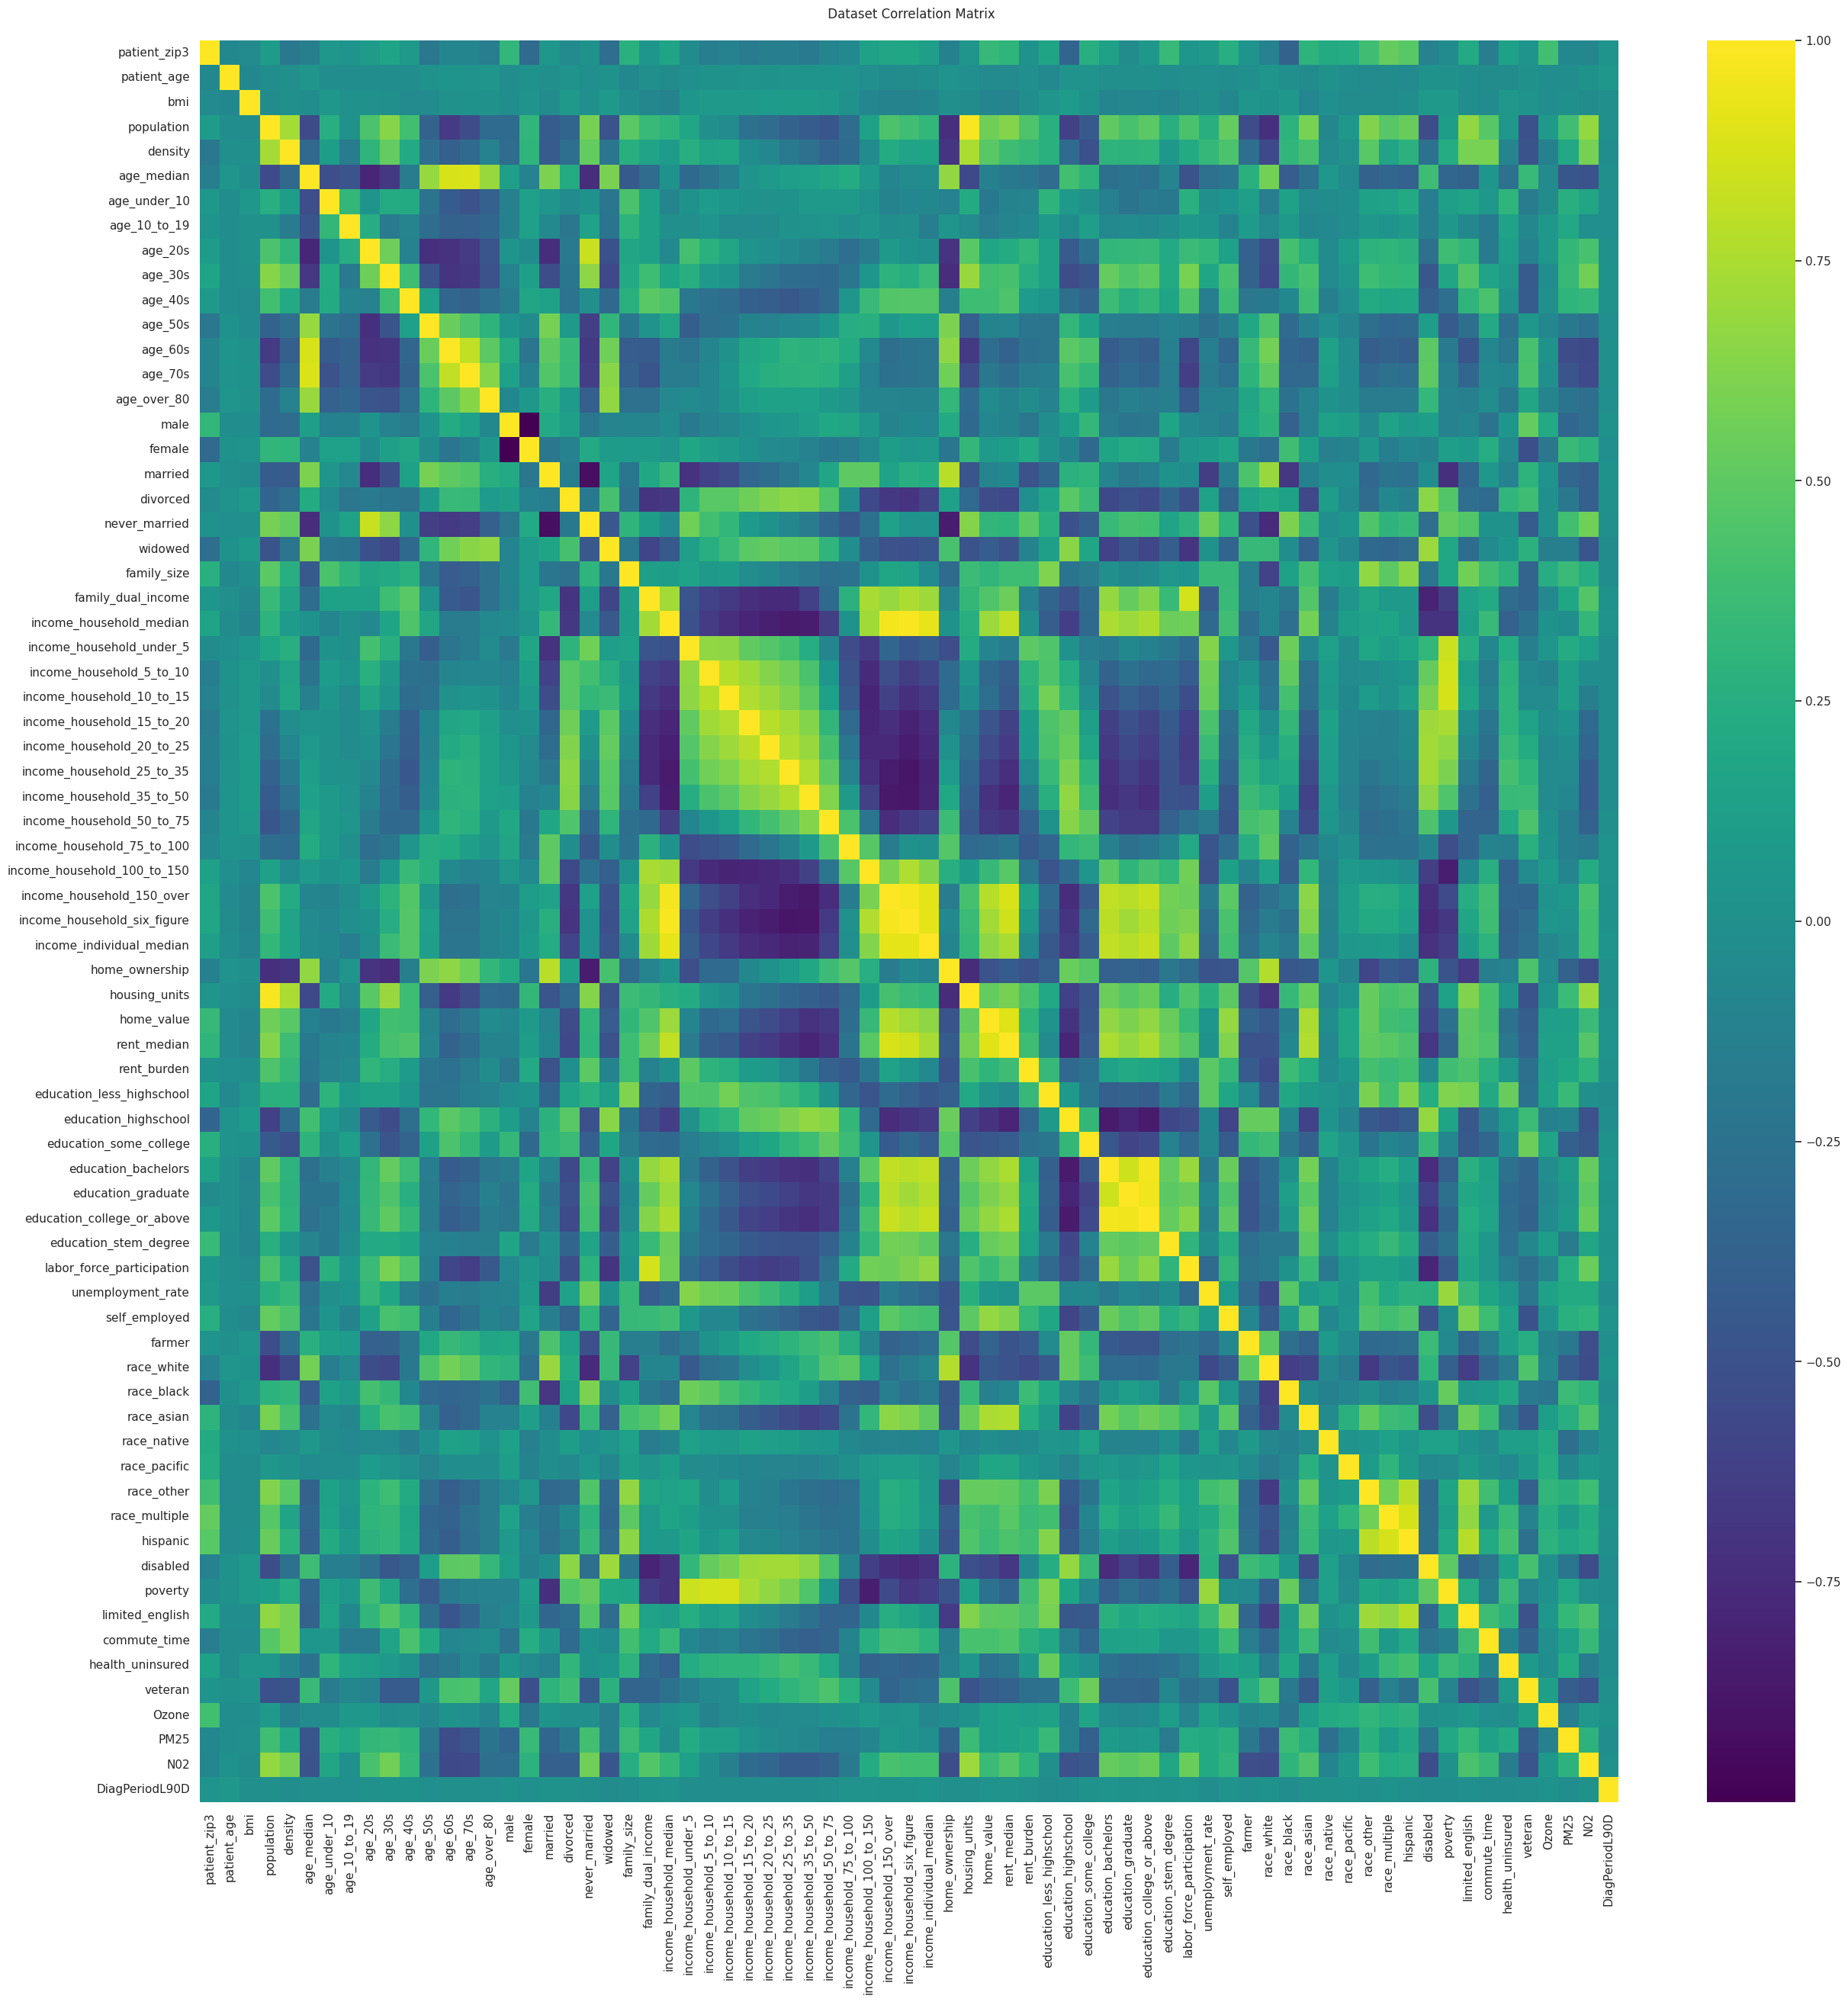

In [82]:
fig , ax = plt.subplots(figsize = (30, 30))
cor = numerical_features.corr()
sns.heatmap(cor, cmap = 'viridis', ax=ax)
plt.title(f' Dataset Correlation Matrix\n')
plt.show()

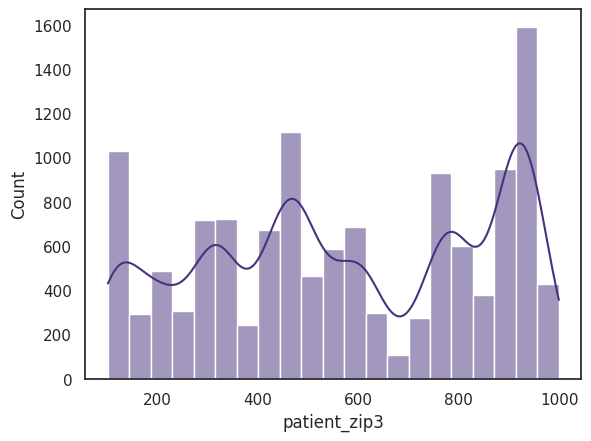

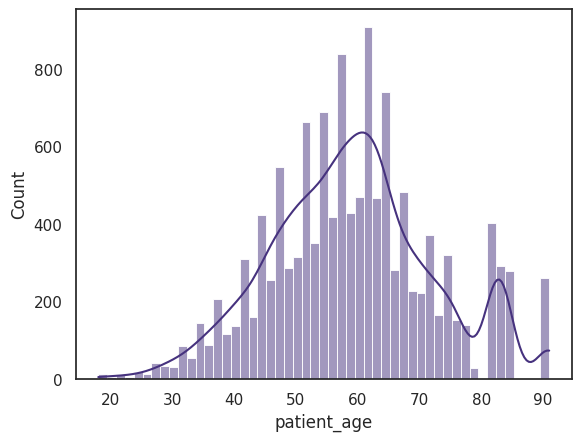

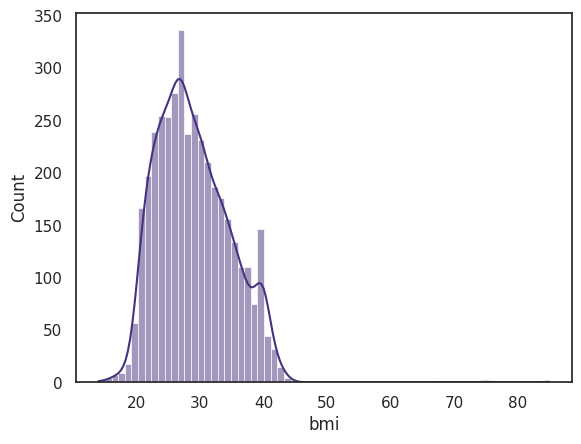

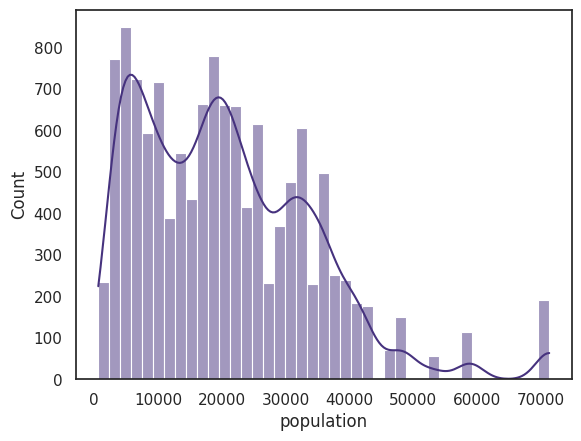

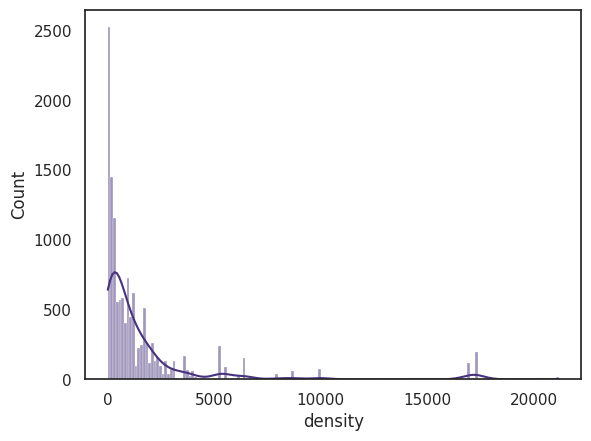

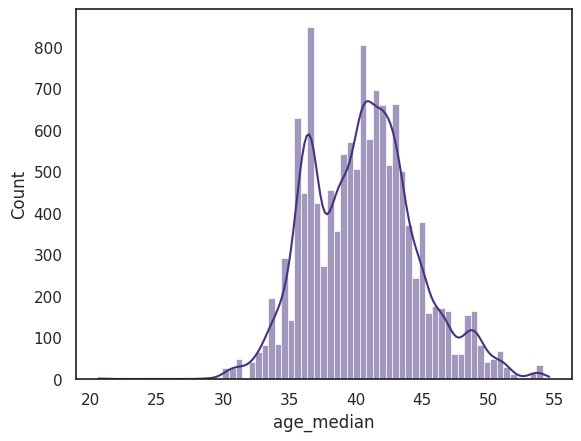

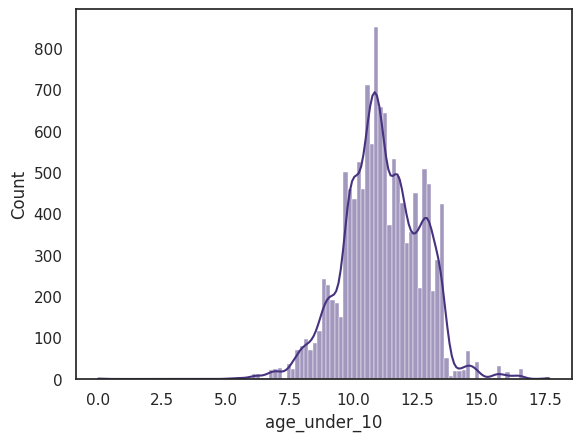

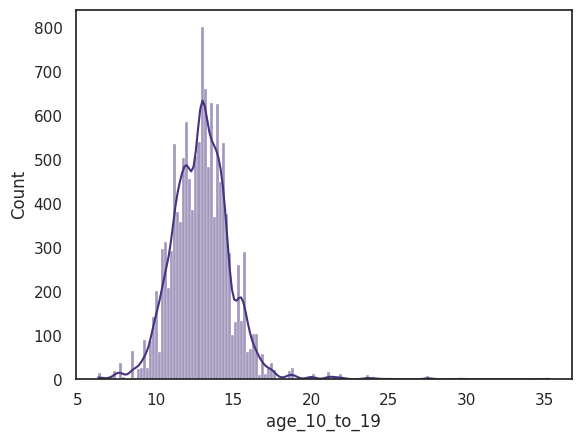

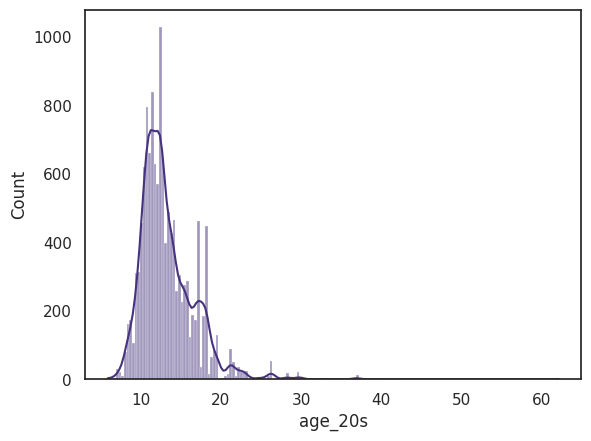

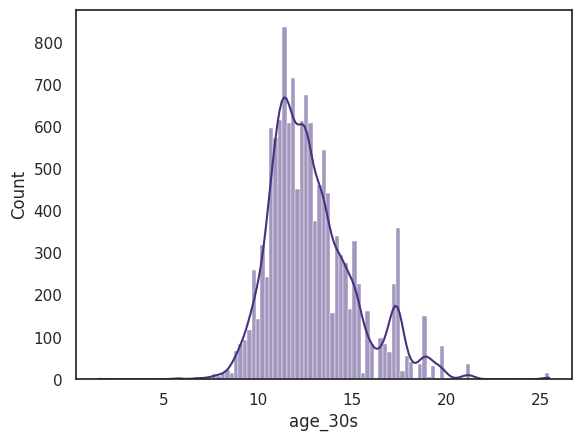

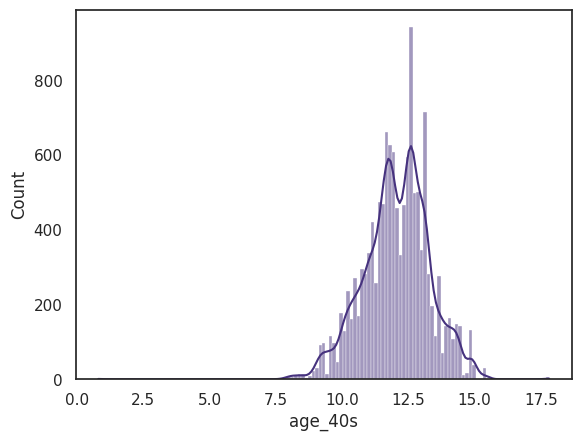

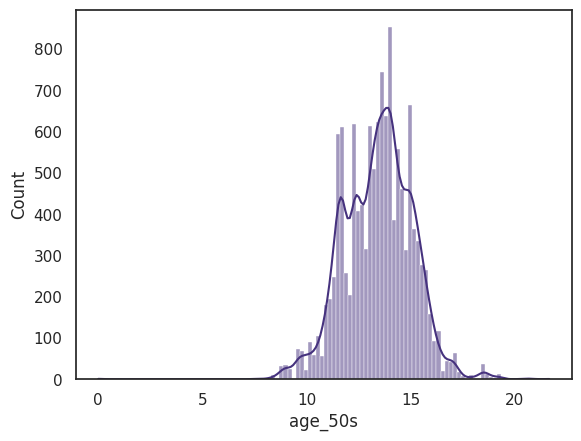

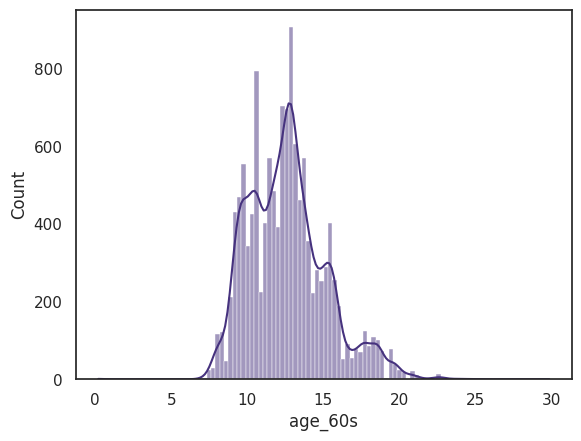

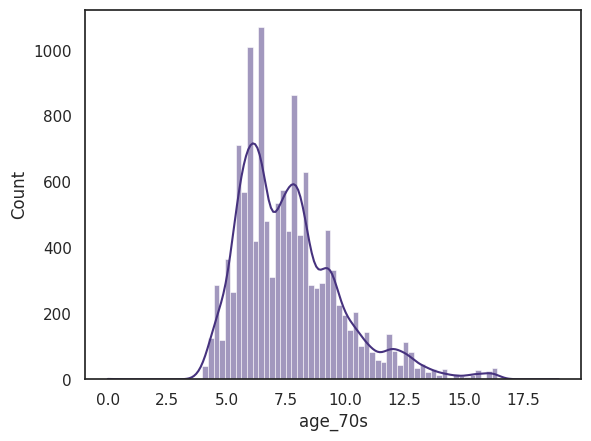

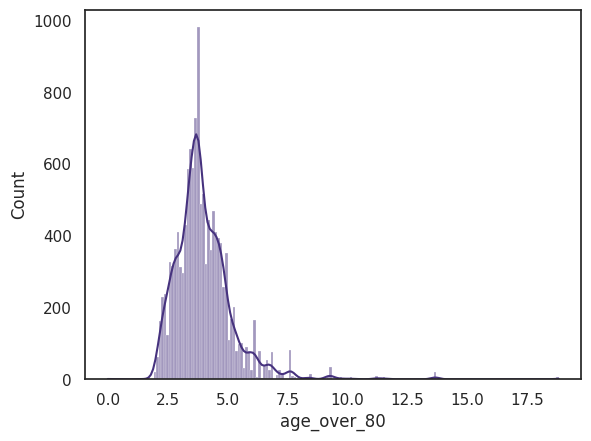

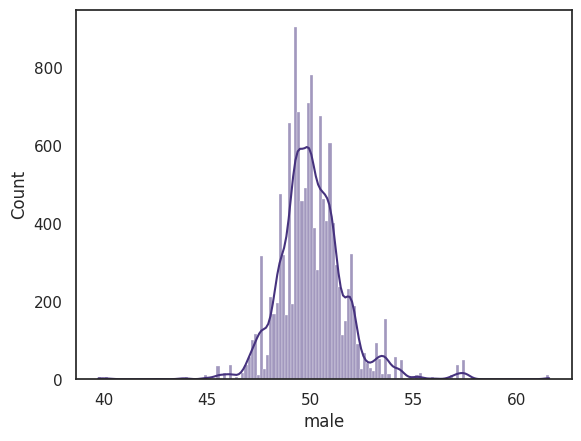

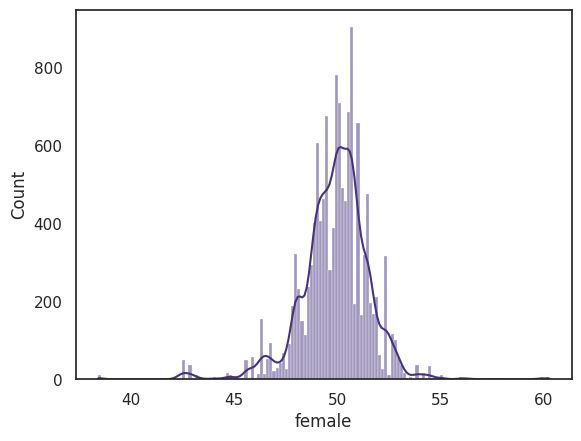

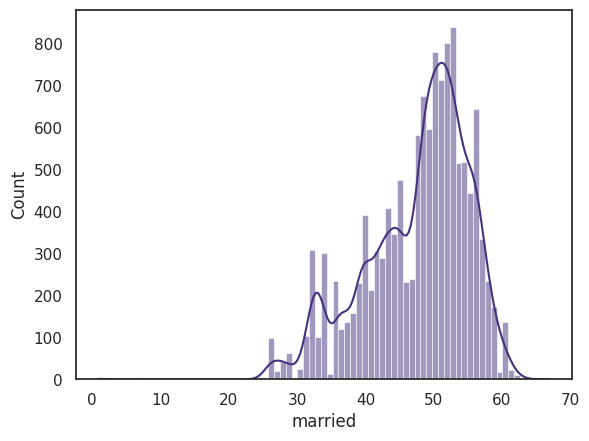

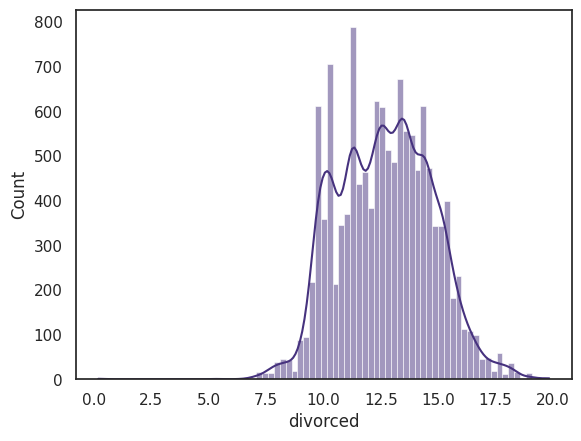

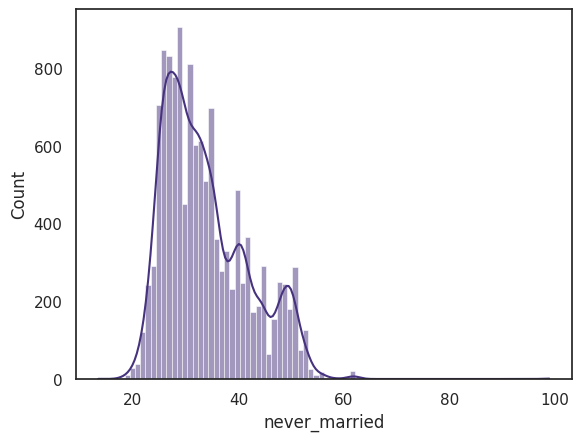

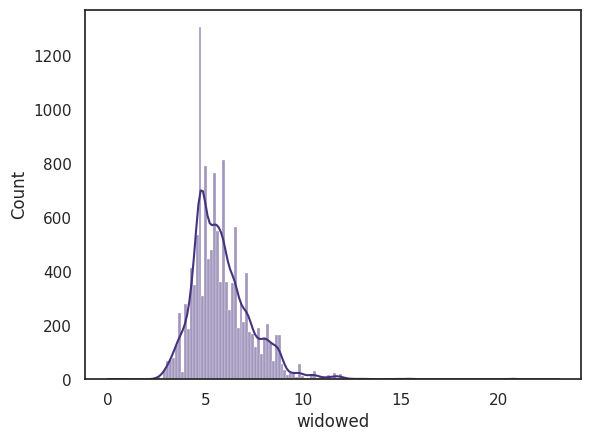

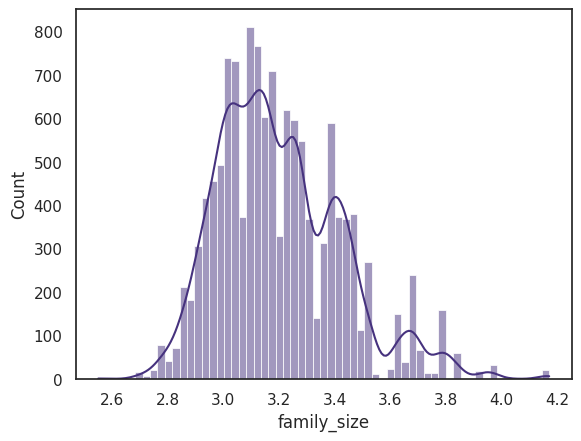

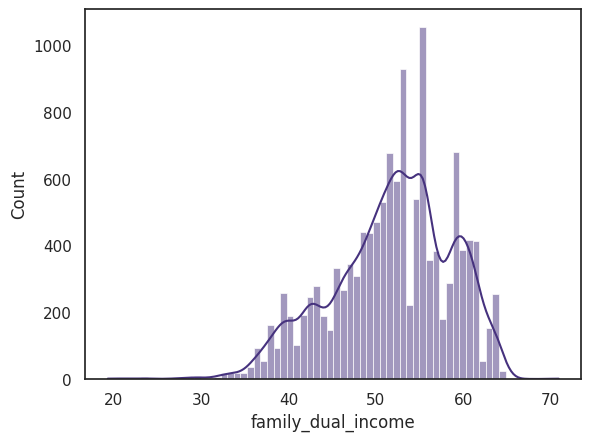

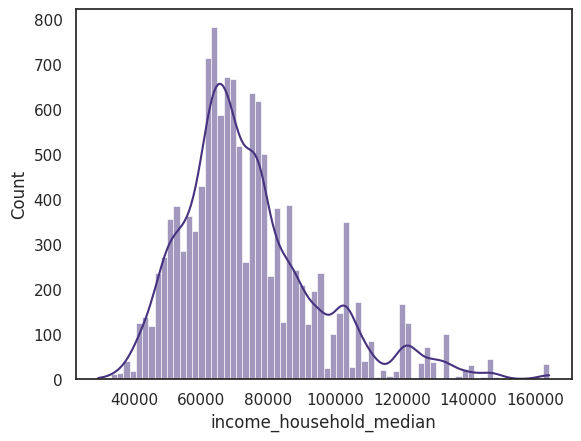

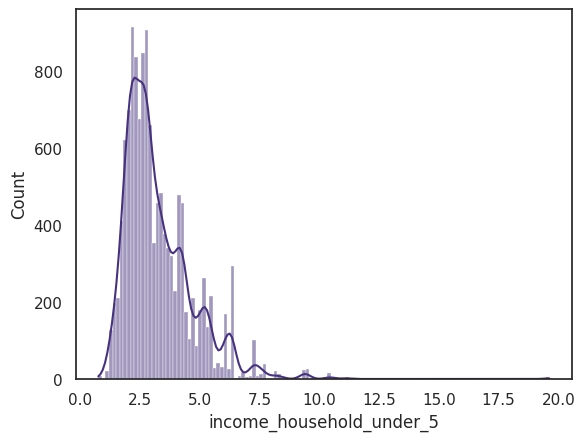

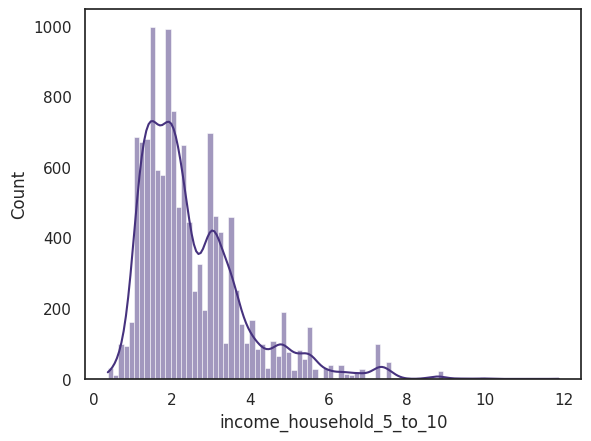

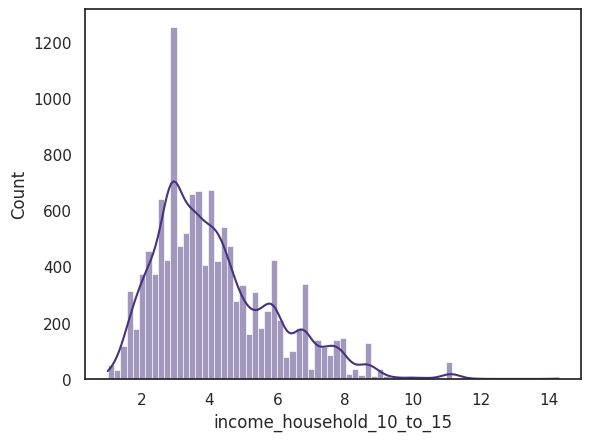

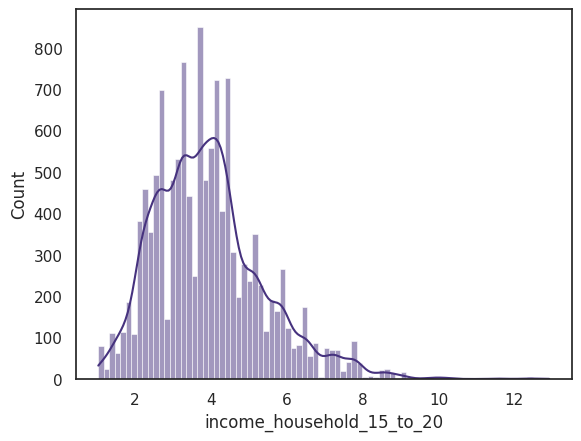

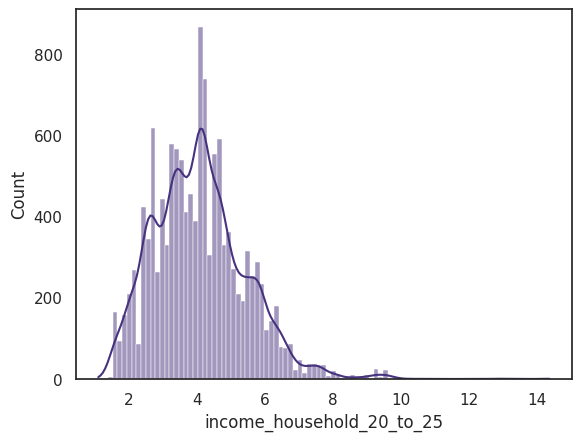

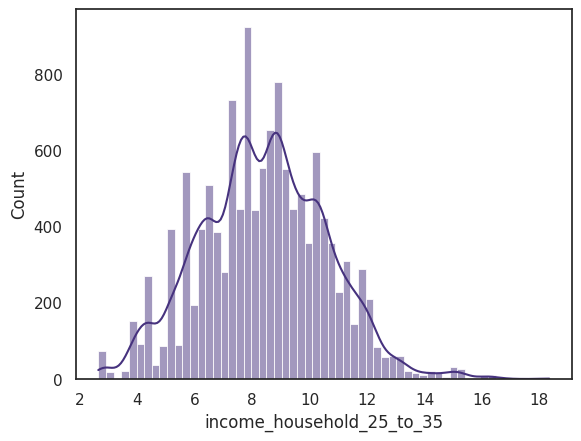

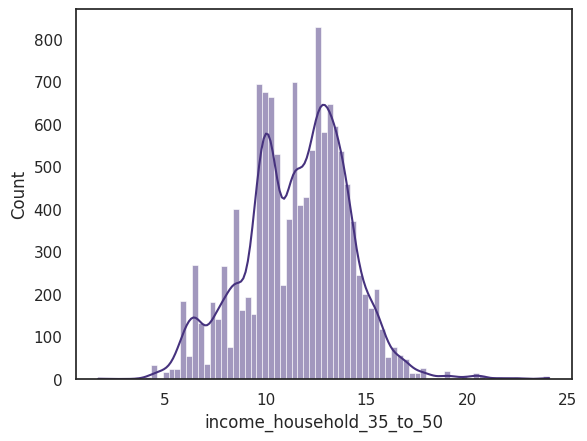

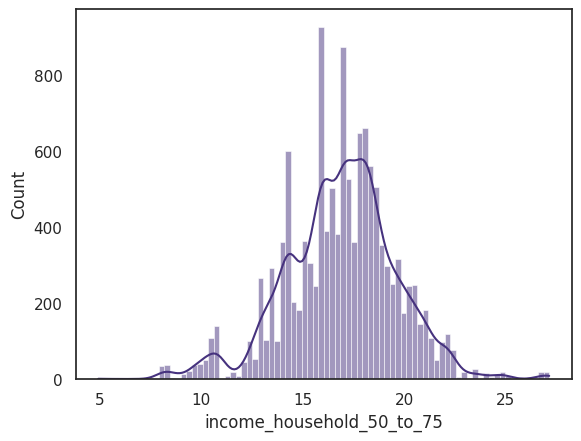

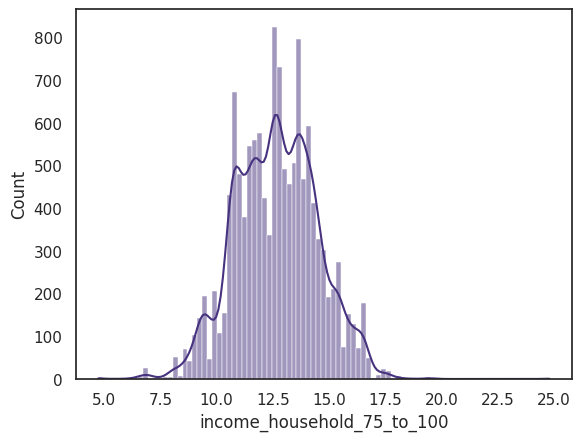

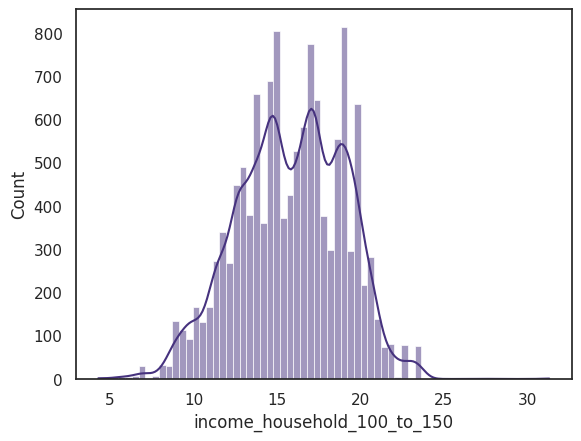

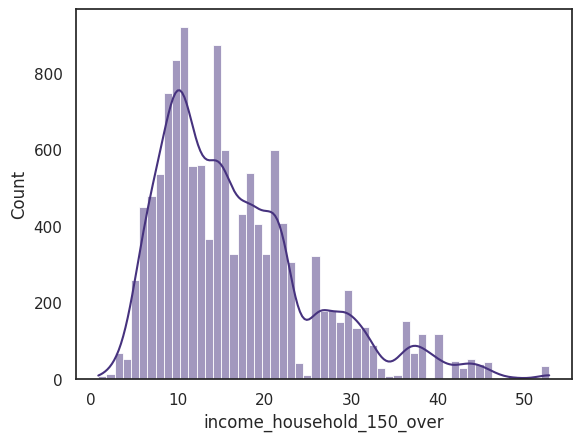

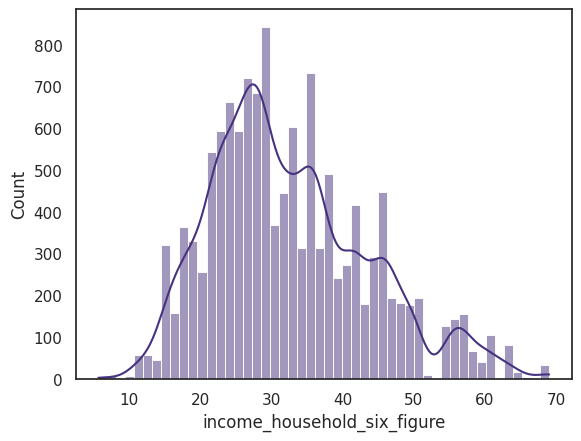

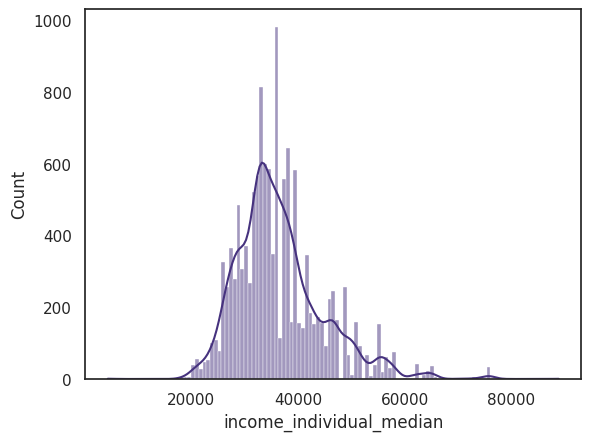

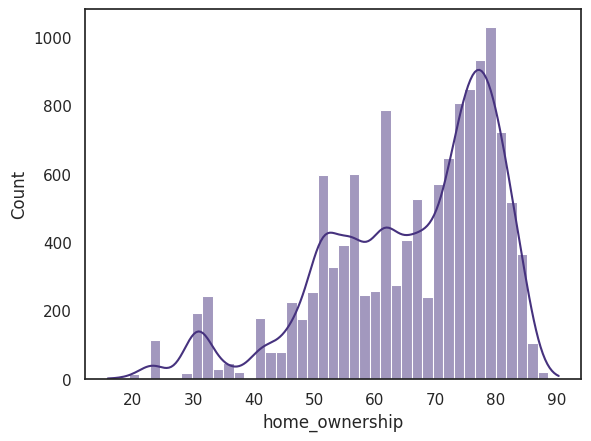

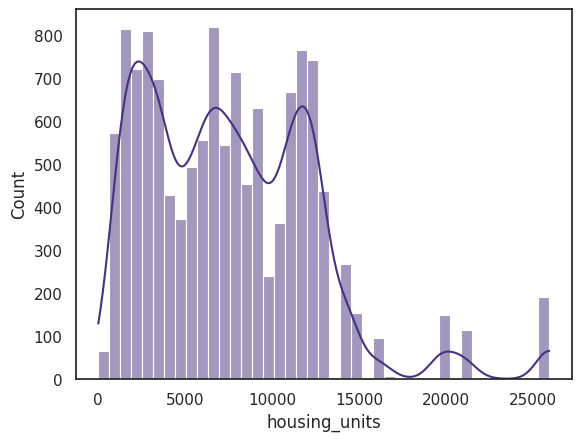

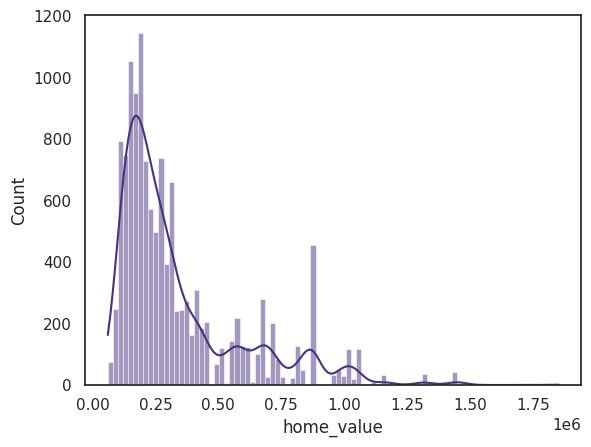

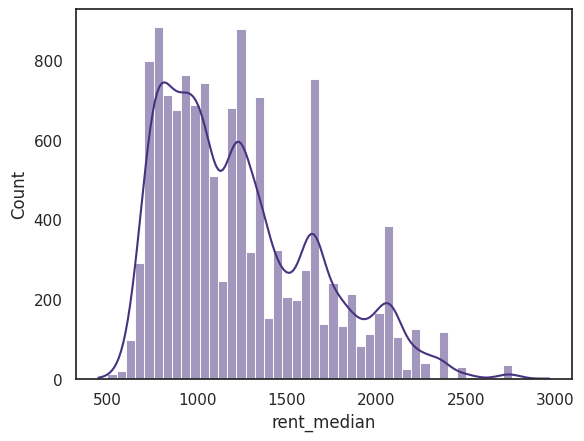

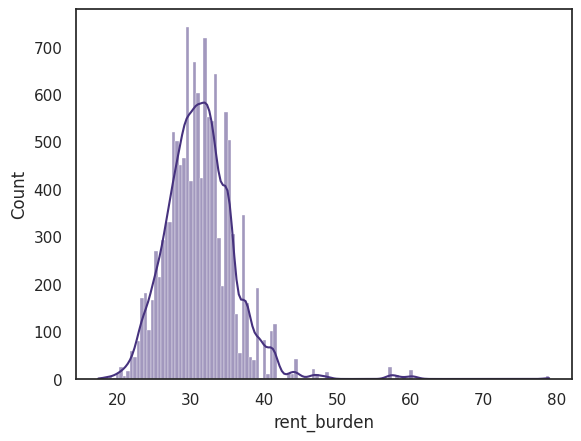

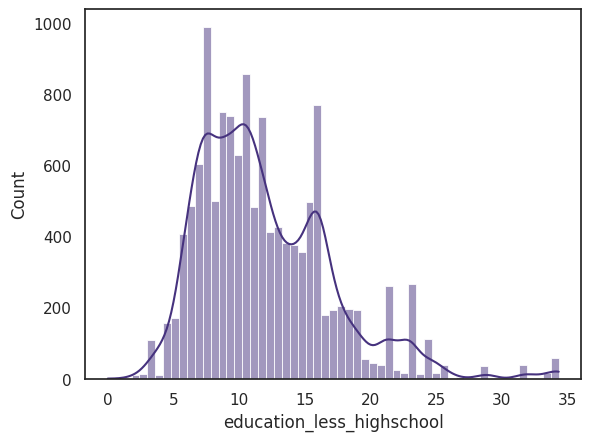

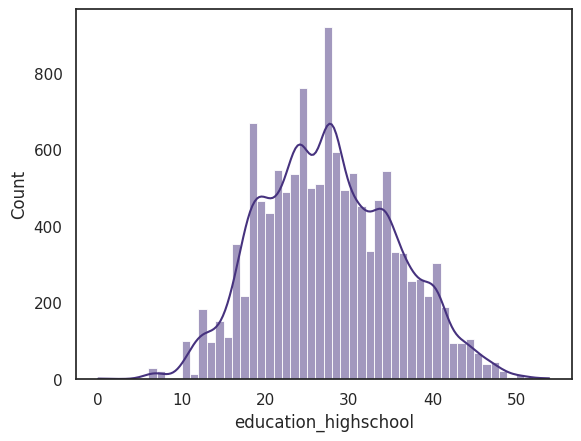

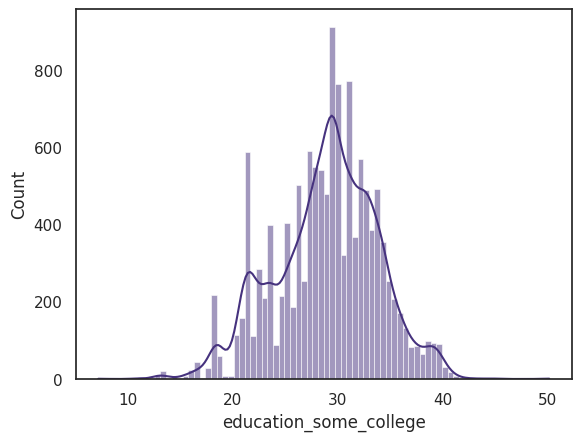

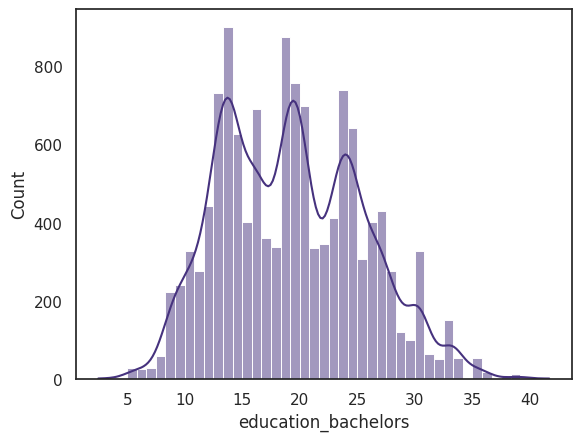

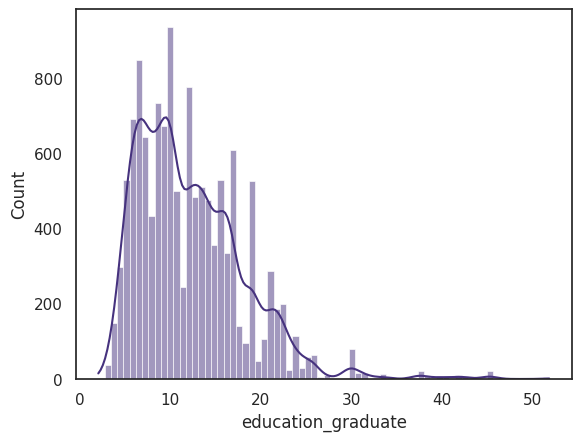

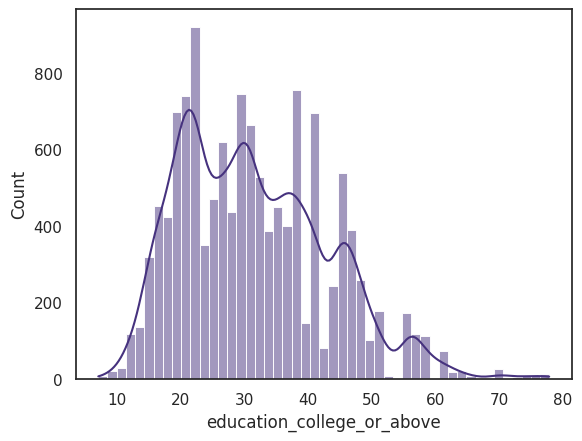

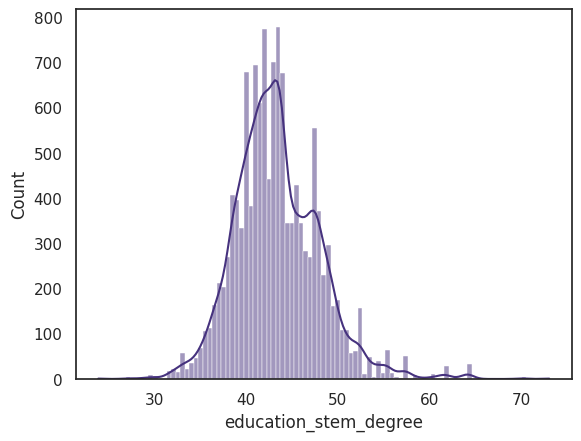

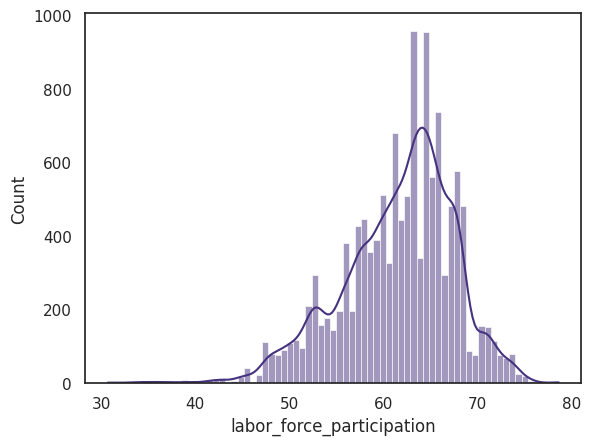

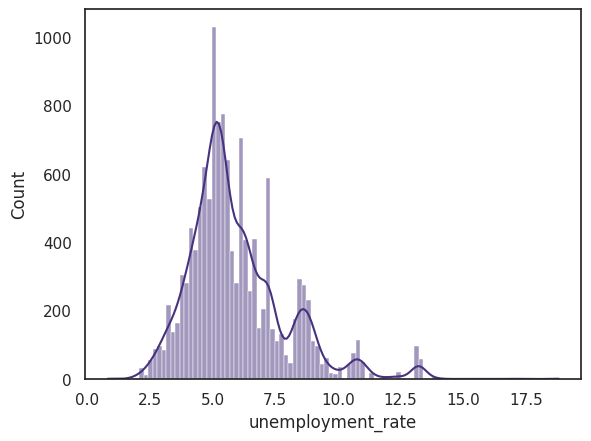

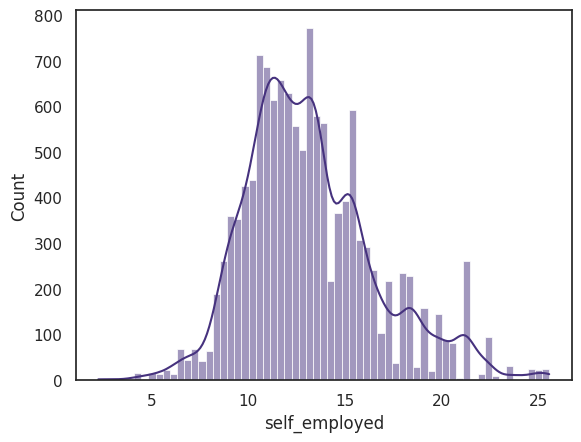

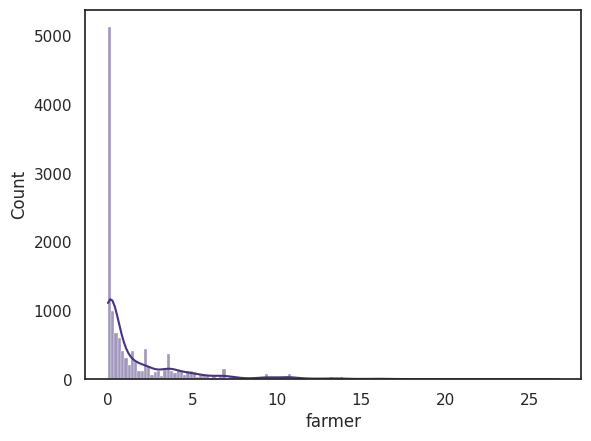

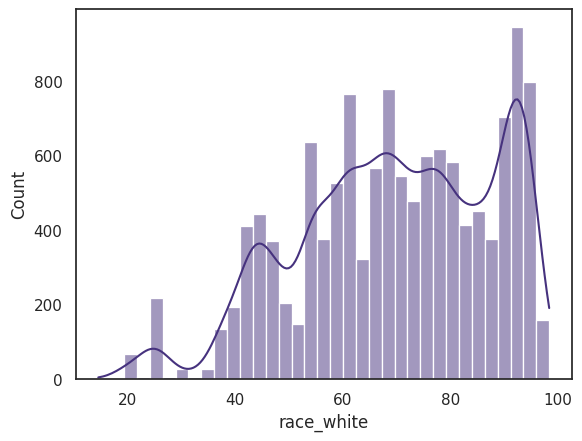

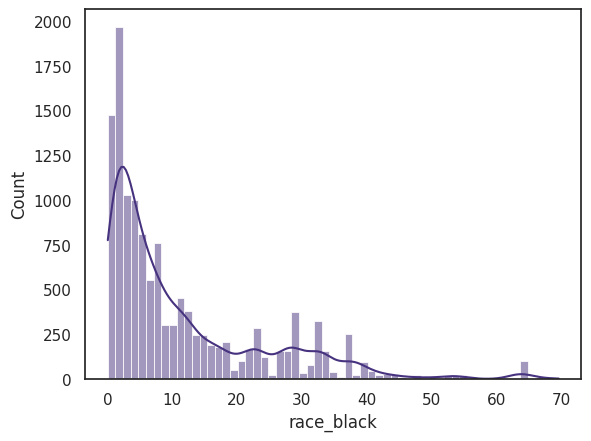

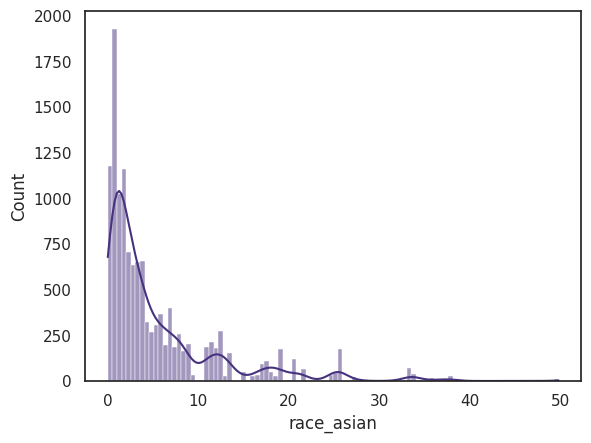

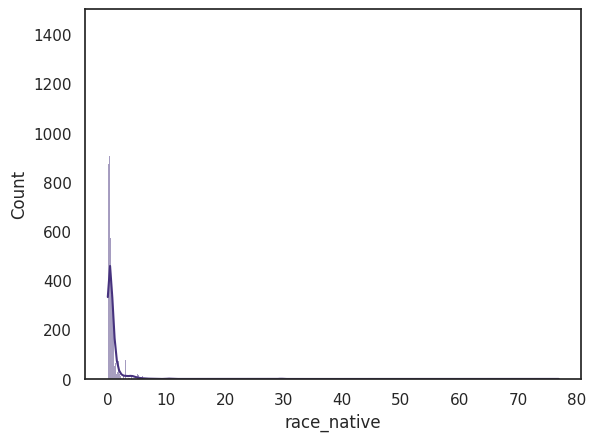

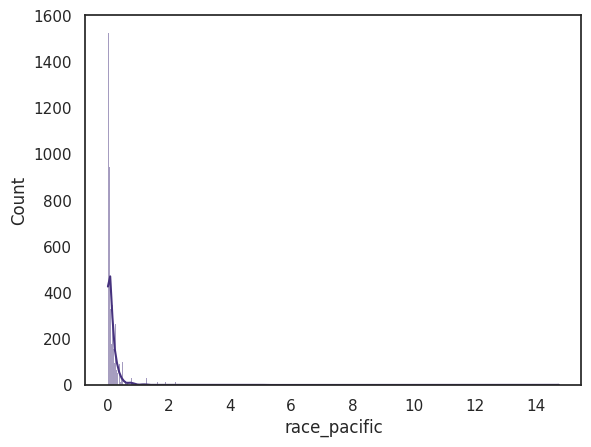

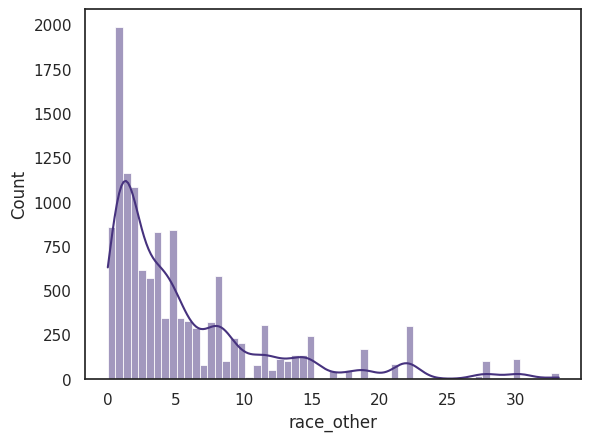

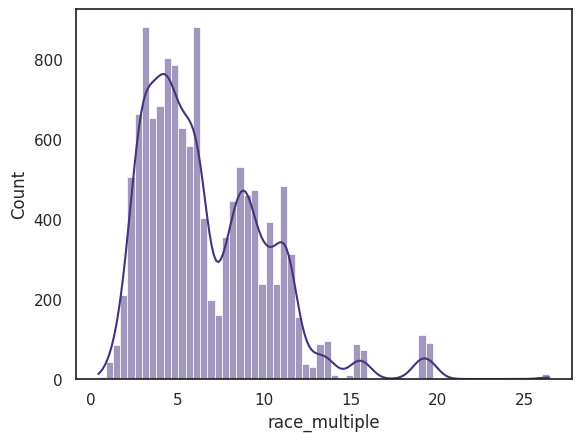

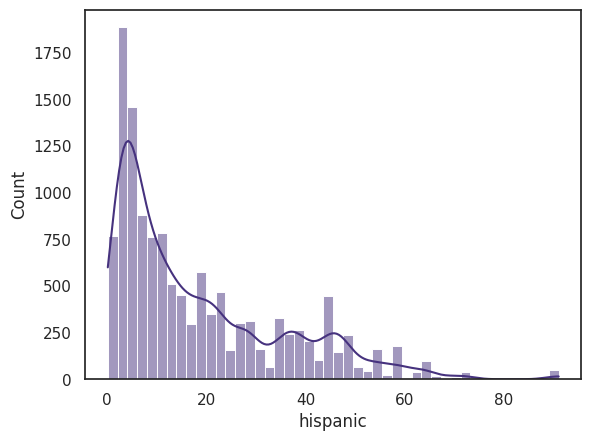

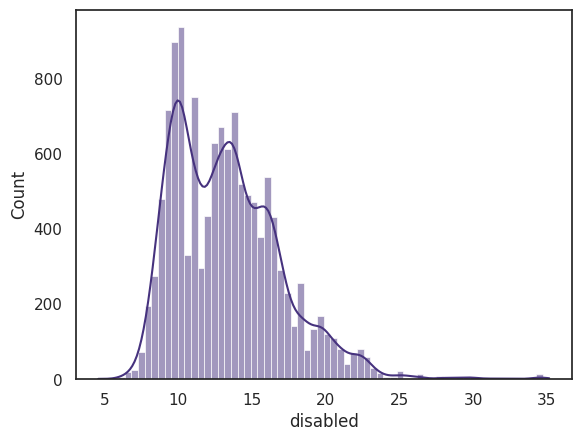

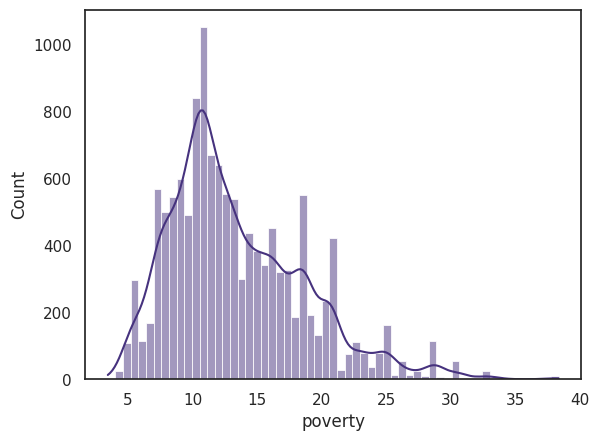

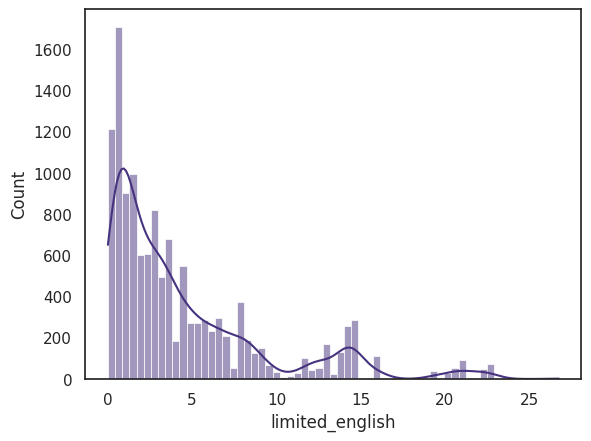

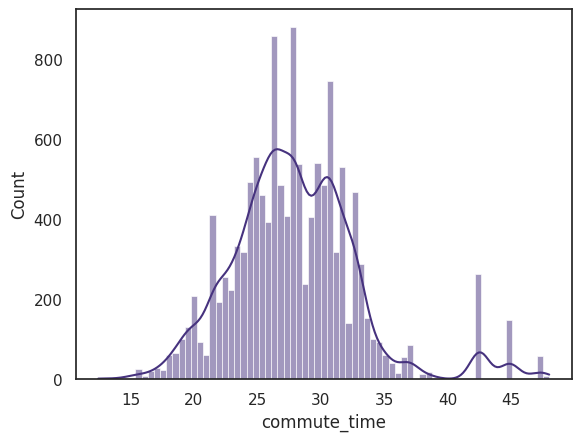

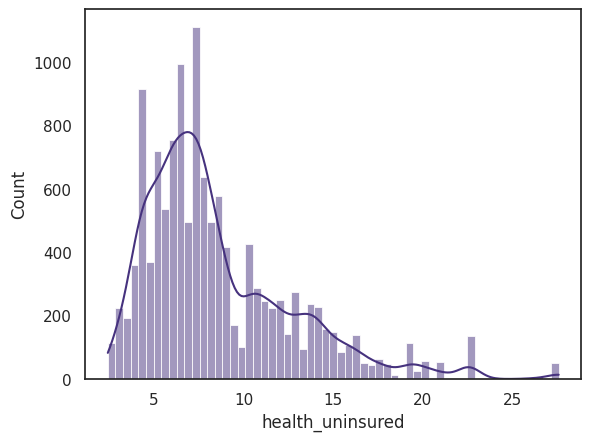

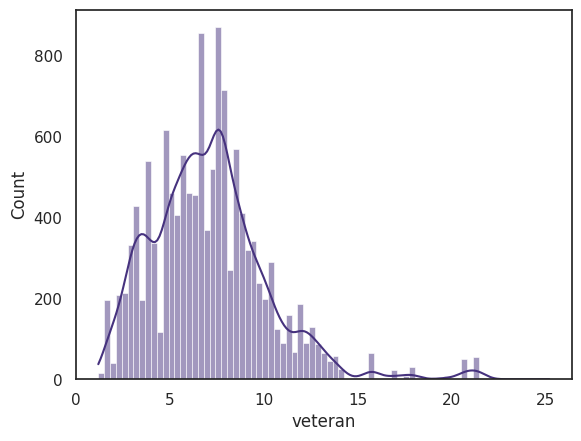

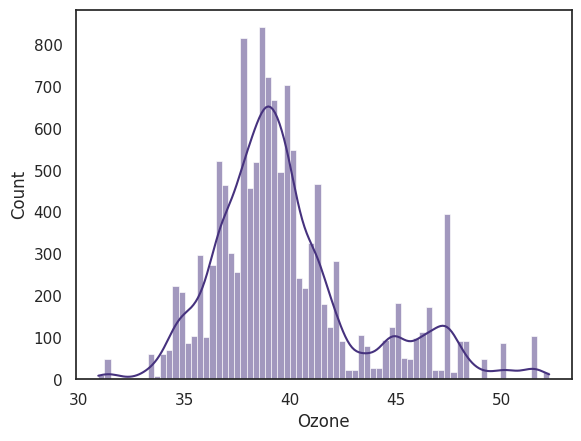

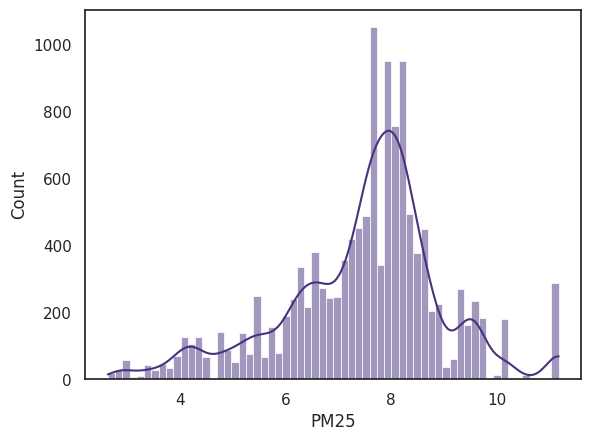

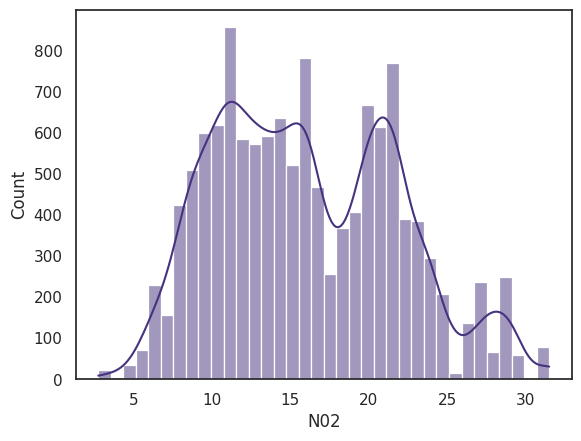

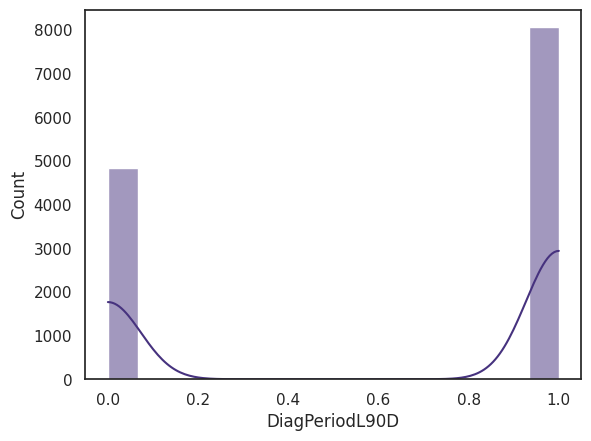

In [83]:
for col in numerical_features.columns:
    sns.histplot(train_df[col], kde = True)
    plt.show()

In [84]:
train_df.drop(['bmi', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'patient_race'], axis = 1, inplace = True)
test_df.drop(['bmi', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'patient_race'], axis = 1, inplace = True)

In [86]:
train_categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()
test_categorical_features = test_df.select_dtypes(include=['object']).columns.tolist()

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the categorical column
for col in train_categorical_features:
    train_df[col] = label_encoder.fit_transform(train_df[col])
for col in test_categorical_features:
    test_df[col] = label_encoder.fit_transform(test_df[col])


In [91]:
imputer = KNNImputer(n_neighbors=3)
imputed_train_data = imputer.fit_transform(train_df)
imputed_test_data = imputer.fit_transform(test_df)
train_df_imputed = pd.DataFrame(imputed_train_data, columns=train_df.columns)
test_df_imputed = pd.DataFrame(imputed_test_data, columns=test_df.columns)

In [90]:
X = train_df_imputed[['payer_type', 'patient_state', 'patient_age', 'patient_gender',
'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code']]
y = train_df_imputed["DiagPeriodL90D"]

# # Define the model
# model = RandomForestRegressor(random_state=42)

# # Set up RFE
# num_features_to_select = 13  # Number of features to select
# rfe = RFE(estimator=model, n_features_to_select=num_features_to_select)

# # Fit RFE to the data
# rfe.fit(X, y)

# # Get the selected features
# selected_features = X.columns[rfe.support_]
# print("Selected Features:")
# print(selected_features)

# # Ranking of features (1 means selected)
# print("\nFeature Rankings:")
# for feature, rank in zip(X.columns, rfe.ranking_):
#     print(f"{feature}: {rank}")

# # Transform the dataset to include only selected features
# X_selected = rfe.transform(X)

# # Optionally, you can convert it back to a DataFrame for better readability
# X_selected_df = pd.DataFrame(X_selected, columns=selected_features)
# print("\nTransformed Dataset (with selected features):")
# print(X_selected_df.head())


In [92]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert datasets to DMatrix (for xgboost)
dtrain = DMatrix(X_train, label=y_train)
dtest = DMatrix(X_val, label=y_val)

# Define XGBoost parameters
params = {
    "objective": "binary:logistic",  # For binary classification
    "eval_metric": "auc",           # AUC as evaluation metric
    "eta": 0.1,                     # Learning rate
    "max_depth": 6,                 # Maximum tree depth
    "subsample": 0.8,               # Subsample ratio of training instances
    "colsample_bytree": 0.8,        # Subsample ratio of columns when constructing trees
    "seed": 42                      # Random seed
}

# Train the XGBoost model
evals = [(dtrain, "train"), (dtest, "test")]
num_rounds = 100  # Number of boosting rounds
model = xgboost.train(params, dtrain, num_rounds, evals, early_stopping_rounds=10, verbose_eval=True)

# Predict probabilities for the test set
y_pred_prob = model.predict(dtest)

# Calculate the AUC score
auc_score = roc_auc_score(y_val, y_pred_prob)
print(f"AUC Score: {auc_score:.4f}")

# Feature importance (optional)
importance = model.get_score(importance_type="weight")
print("\nFeature Importance:")
for feature, score in sorted(importance.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {score}")

[0]	train-auc:0.80235	test-auc:0.78756
[1]	train-auc:0.81854	test-auc:0.78983
[2]	train-auc:0.82353	test-auc:0.79332
[3]	train-auc:0.82425	test-auc:0.79334
[4]	train-auc:0.83095	test-auc:0.79357
[5]	train-auc:0.83427	test-auc:0.79595
[6]	train-auc:0.83692	test-auc:0.79908
[7]	train-auc:0.83809	test-auc:0.80113
[8]	train-auc:0.83818	test-auc:0.80020
[9]	train-auc:0.83788	test-auc:0.80154
[10]	train-auc:0.83785	test-auc:0.80177
[11]	train-auc:0.84007	test-auc:0.80217
[12]	train-auc:0.84118	test-auc:0.80301
[13]	train-auc:0.84180	test-auc:0.80415
[14]	train-auc:0.84259	test-auc:0.80455
[15]	train-auc:0.84379	test-auc:0.80365
[16]	train-auc:0.84493	test-auc:0.80330
[17]	train-auc:0.84594	test-auc:0.80432
[18]	train-auc:0.84653	test-auc:0.80433
[19]	train-auc:0.84747	test-auc:0.80538
[20]	train-auc:0.84865	test-auc:0.80476
[21]	train-auc:0.85001	test-auc:0.80508
[22]	train-auc:0.85039	test-auc:0.80435
[23]	train-auc:0.85133	test-auc:0.80399
[24]	train-auc:0.85146	test-auc:0.80439
[25]	train

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


In [93]:
X_test = test_df_imputed[['payer_type', 'patient_state', 'patient_age', 'patient_gender',
'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code']]

In [99]:
# Assuming 'model' is your trained XGBoost model
dtest = DMatrix(X_test)  # Convert test data to DMatrix
test_predictions = model.predict(dtest)


In [101]:
submission = pd.DataFrame({'patient_id': test_df.index,
                           'DiagPeriodL90D': test_predictions})

In [ ]:
submission.to_csv('predictions.csv', index=False)

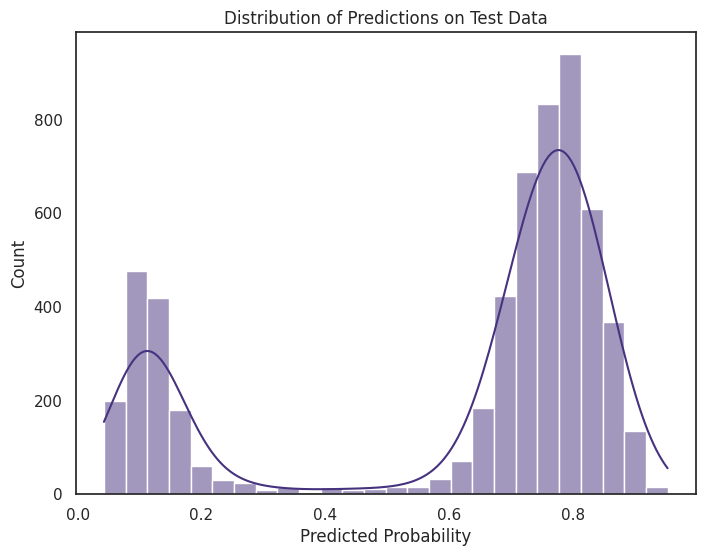

In [100]:
plt.figure(figsize=(8, 6))
sns.histplot(test_predictions, kde=True)
plt.title("Distribution of Predictions on Test Data")
plt.xlabel("Predicted Probability")
plt.show()

# XGBoost

In [62]:
def xgb_objective(trial):
    params = {
        'eta' : trial.suggest_float('eta', .001, .3, log = True),
        'max_depth' : trial.suggest_int('max_depth', 2, 30),
        'subsample' : trial.suggest_float('subsample', .5, 1),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', .1, 1),
        'min_child_weight' : trial.suggest_float('min_child_weight', .1, 20, log = True),
        'reg_lambda' : trial.suggest_float('reg_lambda', .01, 20, log = True),
        'reg_alpha' : trial.suggest_float('reg_alpha', .01, 10, log = True),
        'n_estimators' : 750,
        'random_state' : seed,
        'tree_method' : 'hist',
    }

    optuna_model = make_pipeline(
        MEstimateEncoder(cols = categorical_features),
        FeatureSelector(cols = ['payer_type', 'patient_state', 'patient_age', 'patient_gender', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code']),
        XGBClassifier(**params)
    )

    optuna_score, _, _ = cross_val_score(optuna_model)

    return np.mean(optuna_score)

xgb_study = optuna.create_study(direction = 'maximize')

[I 2024-12-18 16:29:25,651] A new study created in memory with name: no-name-d6afa002-9409-479d-b6c7-9080b46bff0d


In [63]:
#xgb_study.optimize(xgb_objective, 200)

In [ ]:
xgb_params = {'eta': 0.014290460861843577, 'max_depth': 10, 'subsample': 0.891507291340268, 'colsample_bytree': 0.3779121278340872, 'min_child_weight': 0.15457089929898238, 'reg_lambda': 15.22147437968379, 'reg_alpha': 0.9406055353007685}

XGB = make_pipeline(
    MEstimateEncoder(cols = categorical_features),
    FeatureSelector(cols = ['payer_type', 'patient_state', 'patient_age', 'patient_gender', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code']),
    XGBClassifier(**xgb_params, random_state = seed, n_estimators = 750, tree_method = 'hist')
)

_, oof_list['XGB'], predict_list['XGB'] = cross_val_score(XGB, show_importance = False)

In [ ]:
#lgb_study.optimize(lgb_objective, 200)

# CatBoost

In [ ]:
def cb_objective(trial):
    params = {
        'learning_rate' : trial.suggest_float('learning_rate', .001, .1, log = True),
        'max_depth' : trial.suggest_int('max_depth', 2, 12),
        'subsample' : trial.suggest_float('subsample', 0.01, 1, log = True),
        'colsample_bylevel' : trial.suggest_float('colsample_bylevel', .1, 1),
        'min_child_samples' : trial.suggest_int('min_child_samples', 1, 15),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0.01, 1, log = True),
        'n_estimators' : 1000,
        'bootstrap_type' : 'Bernoulli',
        'random_state' : seed,
        'verbose' : 0,
        'has_time' : True
    }

    cb_features = ['patient_race', 'payer_type', 'patient_state', 'patient_age', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'age_under_10', 'unemployment_rate', 'self_employed']
    cb_cat = ['patient_race', 'payer_type', 'patient_state', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code']

    optuna_model = make_pipeline(
        CatImputer,
        FeatureSelector(cb_features),
        CatBoostClassifier(**params, cat_features = cb_cat)
    )

    optuna_score, _, _ = cross_val_score(optuna_model)

    return np.mean(optuna_score)

cb_study = optuna.create_study(direction = 'maximize')

In [ ]:
#cb_study.optimize(cb_objective, 200)

In [ ]:
cb_features = ['payer_type', 'patient_zip3', 'patient_age', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'family_size', 'self_employed']
cb_cat = ['payer_type', 'patient_zip3', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code']

cb_params = {'learning_rate': 0.015116075947127675, 'max_depth': 5, 'colsample_bylevel': 0.5236776088105062, 'min_child_samples': 15, 'reg_lambda': 0.8666134907089579}

CB = make_pipeline(
    CatImputer,
    FeatureSelector(cols = cb_features),
    CatBoostClassifier(random_state = seed, verbose = 0, cat_features = cb_cat)
)

_, oof_list['CB'], predict_list['CB'] = cross_val_score(CB)

In [ ]:
cb_time_features = ['payer_type', 'patient_age', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'income_household_35_to_50']
cb_time_cat = ['payer_type', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code']

cb_time_params = {'learning_rate': 0.02460510521563778, 'max_depth': 4, 'colsample_bylevel': 0.5614033622786926, 'min_child_samples': 9, 'reg_lambda': 0.04325296956640457}

CB_Time = make_pipeline(
    CatImputer,
    FeatureSelector(cols = cb_time_features),
    CatBoostClassifier(random_state = seed, verbose = 0, cat_features = cb_time_cat, has_time = True)
)

_, oof_list['CB_Time'], predict_list['CB_Time'] = cross_val_score(CB_Time)

In [ ]:
print(f'Score: {roc_auc_score(train.DiagPeriodL90D, oof_list.to_numpy() @ weights)}')
predictions = predict_list.to_numpy() @ weights

# Submission

In [ ]:
submission = test.copy()
submission['DiagPeriodL90D'] = predictions

submission.DiagPeriodL90D.to_csv('submission.csv')

In [ ]:
plt.figure(figsize = (15, 10), dpi = 300)
sns.kdeplot(predictions, fill = True)
plt.title("Distribution of DiagPeriodL90D Probability", weight = 'bold', size = 25)
plt.show()